In [241]:
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
hep.set_style(hep.style.CMS) # Used to make nice plots

### Opening single-particle file

In [242]:
import os

data_dir = os.getcwd() + '/../../output/'
particle = 'e-' # Incident particle
angle = 3.459 # Angle in degrees
eta_star = -1.*np.log( np.tan(np.radians(angle)/2.) )
energy = 1 # Beam energy in GeV

file_name = 'eicrecon_out.gen_{particle}_{energy}GeV_theta_{angle}deg.root'.format(particle = particle,
                                                                                   energy = energy,
                                                                                   angle = angle)

with uproot.open("{file}:events".format(file = data_dir + file_name)) as events:
    print("Opening {file}".format(file = data_dir + file_name))
    print("Number of events: {num_events}".format(num_events = events.num_entries))
    desired_branches = events.arrays(["MCParticles", "EcalEndcapPInsertRecHits", "EcalEndcapPRecHits", "HcalEndcapPInsertRecHits"])

mcparticles = desired_branches["MCParticles"]
ecal_insert = desired_branches["EcalEndcapPInsertRecHits"]
hcal_insert = desired_branches["HcalEndcapPInsertRecHits"]
ecal = desired_branches["EcalEndcapPRecHits"]

Opening /home/ryan/ePIC/ePIC_insert_studies/analysis/validation/../../output/eicrecon_out.gen_e-_1GeV_theta_3.459deg.root
Number of events: 1000


### MCParticles quality assurance plots

Event PDG: [11, 11, 11, 11, 11, 11, 11, 11, 11, ..., 11, 11, 11, 11, 11, 11, 11, 11, 11]


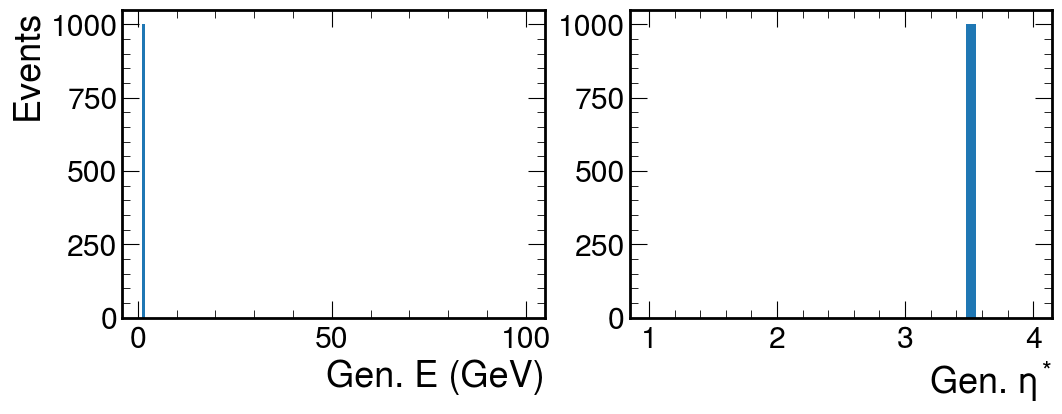

In [243]:
def rotateY(xdata, zdata, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    rotatedz = c*zdata - s*xdata
    rotatedx = s*zdata + c*xdata
    return rotatedx, rotatedz

# Obtaining final state particle
cut_primary = mcparticles["MCParticles.generatorStatus"] == 1

# Getting particle type
gen_pdg = mcparticles["MCParticles.PDG"][cut_primary]
print("Event PDG:",ak.flatten(gen_pdg))

# Getting momentum
gen_px = mcparticles["MCParticles.momentum.x"][cut_primary]
gen_py = mcparticles["MCParticles.momentum.y"][cut_primary]
gen_pz = mcparticles["MCParticles.momentum.z"][cut_primary]

# Rotating px and pz to proton beam
gen_px, gen_pz = rotateY(gen_px, gen_pz, .025)
gen_phi = np.arctan2(gen_py, gen_px) * 180. / np.pi

# Calculating various quantites of generated particles
gen_mass = branches["MCParticles.mass"][cut_primary]
gen_pt = np.sqrt(gen_px**2 + gen_py**2)
gen_mom = np.sqrt(gen_px**2 + gen_py**2 + gen_pz**2)
gen_energy = np.sqrt(gen_mom**2 + gen_mass**2)
gen_theta = np.arccos(gen_pz/gen_mom)
gen_theta_deg = np.degrees(gen_theta)
gen_eta_star = -1.*np.log( np.tan(gen_theta/2.) )

# Histograms of generated particle quantities
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.hist(ak.flatten(gen_energy), bins=100, range=[1,100])
ax1.set_xlabel('Gen. E (GeV)')
ax1.set_ylabel('Events')

ax2.hist(ak.flatten(gen_eta_star), bins=4*10, range=[1,4])
ax2.set_xlabel('Gen. $\eta^*$')
plt.show()

### Getting detector information

In [244]:
ecal_insert_energy = ecal_insert["EcalEndcapPInsertRecHits.energy"]
hcal_insert_energy = hcal_insert["HcalEndcapPInsertRecHits.energy"]
ecal_energy = ecal["EcalEndcapPRecHits.energy"]

### Total energy in each event

[[0.623, 0.0488, 0.0427, 0.0488], ..., [0.0488, 0.0732, ..., 0.0549, 0.061]]
[0.763, 0.311, 0, 0.122, 0.592, 0.763, ..., 0.885, 0.598, 0.269, 0.684, 0.769]


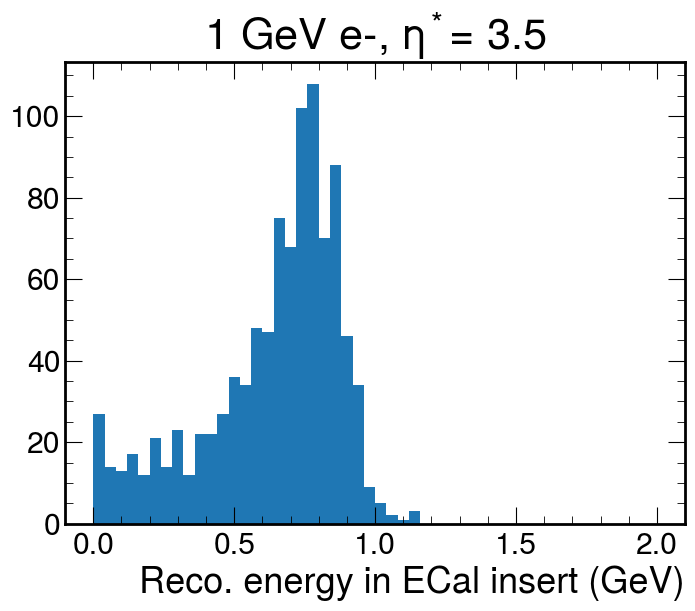

In [245]:
print(ecal_insert_energy)
event_energy = ak.sum(ecal_insert_energy, 1)
print(event_energy)

fig = plt.figure( figsize=(8, 6))

plt.hist(event_energy,bins=50, range=(0, 2))
plt.xlabel('Reco. energy in ECal insert (GeV)')
plt.title('{energy} GeV e-, $\eta^*$= {eta_star}'.format(energy = energy, eta_star = round(eta_star,2)))
plt.show()

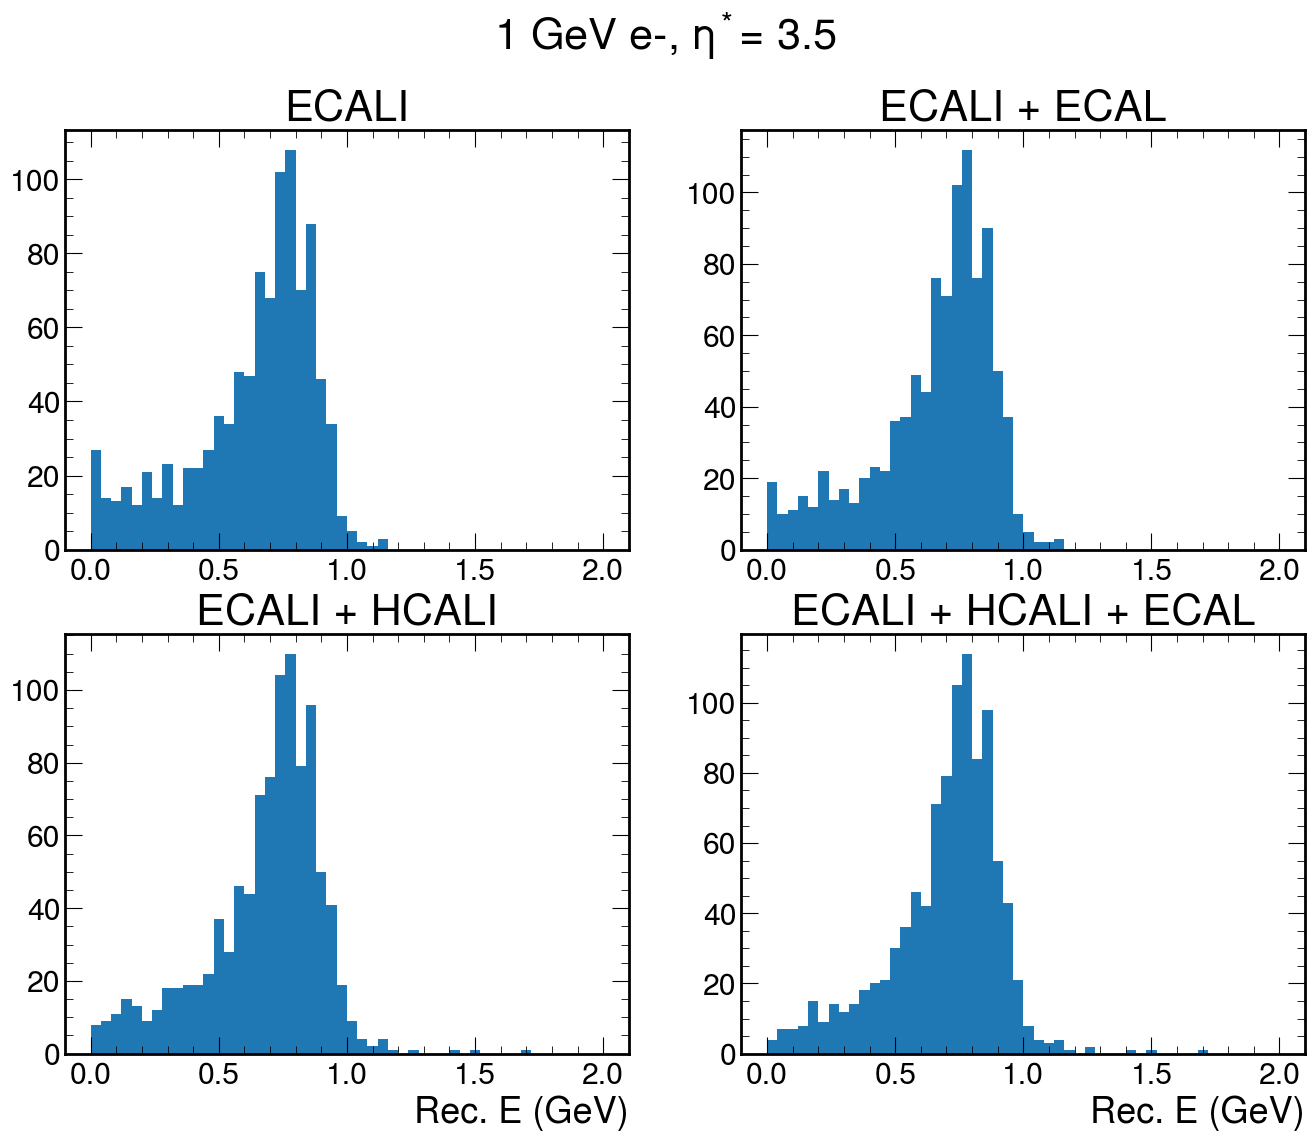

In [246]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,12))
ax1.hist(ak.sum(ecal_insert_energy, 1), bins=50, range=[0,2])
ax1.set_title("ECALI")

ax2.hist(ak.sum(ecal_insert_energy, 1) + ak.sum(ecal_energy, 1), bins=50, range=[0,2])
ax2.set_title("ECALI + ECAL")

ax3.hist(ak.sum(ecal_insert_energy, 1) + ak.sum(hcal_insert_energy, 1), bins=50, range=[0,2])
ax3.set_xlabel('Rec. E (GeV)')
ax3.set_title("ECALI + HCALI")

ax4.hist(ak.sum(ecal_insert_energy, 1) + ak.sum(hcal_insert_energy, 1) + ak.sum(ecal_energy, 1), bins=50, range=[0,2])
ax4.set_xlabel('Rec. E (GeV)')
ax4.set_title("ECALI + HCALI + ECAL")

fig.suptitle('{energy} GeV e-, $\eta^*$= {eta_star}'.format(energy = energy, eta_star = round(eta_star,2)))
plt.show()
